## Extended Trapping SINDy
By Alan Kaptanoglu

A very common issue is that models identified by system identification methods typically have no guarantees that the models are numerically or physically stable. This can be addressed with heuristic, data-driven, or analytic closure models, but we have recently directly promoted globally stable models into the system identification itself (see the Example 8 Jupyter notebook). This is really nice but there are three potential caveats, (1) the regression is nonconvex and there a number of hyperparameters, so this method can be difficult to learn, and (2) in order to promote global stability, one needs an analytic result from stability theory, and the one we use applies only for quadratically nonlinear dynamics (typically fluid and plasma flows) with energy-preserving, quadratic, nonlinearities. Moreover, we have now (3) additionally shown that generic quadratically nonlinear models will always be globally *unbounded*, so for these situations we can also promote local Lyapunov stability of the origin using some variations of the original Trapping SINDy algorithm. That is the goal of this notebook -- to illustrate how various forms of global and local stability can be promoted explicitly in the SINDy method to obtain stable data-driven models.

For the following, we will consider dynamical models of the form
$$\dot{x}_i = C_i +  L_{ij}x_j + Q_{ijk}x_ix_j.$$
For global stability promotion, we will require skew-symmetry in the quadratic coefficients
$$ Q_{ijk} + Q_{jik} + Q_{kij} = 0.$$
This equation will be implemented as a hard constraint in the optimization. However, for dynamical models that do not satisfy this condition, we can still promote locally stable models that are stable even at fairly large distances of the origin. The following examples show different ways to relax this hard constraint.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import scipy.io as sio
from pysindy.utils import lorenz

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [47]:
# Define some setup and plotting functions
# Build the skew-symmetric nonlinearity constraints
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0) + 1  # + 1 for constant term
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    # [1, x, y, z, xy, xz, yz, x2, y2, z2, 1, ...]
    # [1 1 1 x x x y y y ...]
    for i in range(r):
        # constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 3.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r + r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r + r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r + r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1 / 2.0
                constraint_matrix[q, r + r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1 / 2.0
                constraint_matrix[q, r + r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1 / 2.0
                q = q + 1

    return constraint_zeros, constraint_matrix


# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
def check_stability(r, Xi, mod_matrix, sindy_opt, mean_val):
    opt_m = sindy_opt.m_history_[-1]
    PC_tensor = sindy_opt.PC_
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PM_tensor = sindy_opt.PM_
    PQ_tensor = sindy_opt.PQ_
    mPM = np.tensordot(PM_tensor, opt_m, axes=([2], [0]))
    P_tensor = PL_tensor + mPM
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    As = mod_matrix @ As
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    C = np.tensordot(PC_tensor, Xi, axes=([2, 1], [0, 1]))
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = C + np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    d = mod_matrix @ d
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    Reff = Rm / mean_val
    print('Estimate of trapping region size, Rm = ', Rm)
    print('Normalized trapping region size, Reff = ', Reff)

def check_stability_new(r, Xi, mod_matrix, sindy_opt, mean_val):
    opt_m = sindy_opt.m_history_[-1]
    PC_tensor = sindy_opt.PC_
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PM_tensor = sindy_opt.PM_
    PQ_tensor = sindy_opt.PQ_
    mPM = np.tensordot(PM_tensor, opt_m, axes=([2], [0]))
    P_tensor = PL_tensor + mPM
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    As = mod_matrix @ As
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    max_eigval = np.sort(eigvals)[-1]
    C = np.tensordot(PC_tensor, Xi, axes=([2, 1], [0, 1]))
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
    d = C + np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    d = mod_matrix @ d
    eps_Q = np.max(np.abs(Q_sum))
    delta = max_eigval ** 2 - 4 * np.sqrt(r ** 3) * eps_Q * np.linalg.norm(d, 2) / 3
    if delta < 0:
        Rm = 0
    else:
        Rm = (3 / (2 * np.sqrt(r ** 2) * eps_Q)) * (-max_eigval + np.sqrt(delta))
    Reff = Rm / mean_val
    print('Estimate of trapping region size, Rm = ', Rm)
    print('Normalized trapping region size, Reff = ', Reff)

    return Rm


# use optimal m, calculate and plot the stability radius when the third-order
# energy-preserving scheme slightly breaks
def make_DA_progress_plots(r, mod_matrix, sindy_opt):
    PC_tensor = sindy_opt.PC_
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PQ_tensor = sindy_opt.PQ_
    ms = sindy_opt.m_history_
    eigs = sindy_opt.PWeigs_history_
    coef_history = sindy_opt.history_
    rhos = []
    for i in range(len(eigs)):
        if eigs[i][-1] < 0:
            # Q = np.tensordot(sindy_opt.PQ_, coef_history[i], axes=([4, 3], [1, 0]))
            # Q_sum = Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])
            C = np.tensordot(PC_tensor, coef_history[i], axes=([2, 1], [1, 0]))
            L = np.tensordot(PL_tensor_unsym, coef_history[i], axes=([3, 2], [1, 0]))
            Q = np.tensordot(PQ_tensor, coef_history[i], axes=([4, 3], [1, 0]))
            Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
            d = C + np.dot(L, ms[i]) + np.dot(np.tensordot(Q, ms[i], axes=([2], [0])), ms[i])
            d = mod_matrix @ d
            eps_Q = np.max(np.abs(Q_sum))
            Rm = (3 / (2 * np.sqrt(r ** 2) * eps_Q)) \
                    * (np.sqrt(eigs[i][-1] ** 2 - 4 * np.sqrt(r ** 3) \
                               * eps_Q * np.linalg.norm(d, 2)/3) - eigs[i][-1])
            if Rm > 0:
                rhos.append(Rm)
            else:
                rhos.append(0)
            # rhos.append(-eigs[i][-1] / np.max(np.abs(Q_sum)))
    print(np.linalg.norm(d, 2))
    plt.plot(rhos[1:])
    plt.grid(True)
    plt.ylabel('Stability radius')
    plt.xlabel('Algorithm iteration')
    plt.show()


# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 
             'r', label='true x')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 
             'k', label='pred x')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.legend(fontsize=14)
    plt.show()


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(16, 8))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r', 
                 label=r'true $\dot{x}_' + str(i) + '$')
        plt.plot(t, xdot_test_pred[:, i], 'k--', 
                 label=r'pred $\dot{x}_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r', label=r'true $x_' + str(i) + '$')
        plt.plot(t, x_test_pred[:, i], 'k--', label=r'pred $x_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        
    plt.show()
    
    
# Plot errors between m_{k+1} and m_k and similarly for the model coefficients
def make_progress_plots(r, sindy_opt):
    W = np.asarray(sindy_opt.history_)
    M = np.asarray(sindy_opt.m_history_)
    dW = np.zeros(W.shape[0])
    dM = np.zeros(M.shape[0])
    for i in range(1,W.shape[0]):
        dW[i] = np.sum((W[i, :, :] - W[i - 1, :, :]) ** 2)
        dM[i] = np.sum((M[i, :] - M[i - 1, :]) ** 2)
    plt.figure()
    plt.semilogy(dW, label=r'Coefficient progress, $\|\xi_{k+1} - \xi_k\|_2^2$')
    plt.semilogy(dM, label=r'Vector m progress, $\|m_{k+1} - m_k\|_2^2$')
    plt.xlabel('Algorithm iterations', fontsize=16)
    plt.ylabel('Errors', fontsize=16)
    plt.legend(fontsize=14)
    PWeigs = np.asarray(sindy_opt.PWeigs_history_)
    plt.figure()
    for j in range(r):
        if np.all(PWeigs[:, j] > 0.0):
            plt.semilogy(PWeigs[:, j], 
                         label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        else:
            plt.plot(PWeigs[:, j], 
                     label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        plt.xlabel('Algorithm iterations', fontsize=16)
        plt.legend(fontsize=12)
        plt.ylabel(r'Eigenvalues of $P\xi$', fontsize=16)

# Initialize quadratic SINDy library, with custom ordering 
# to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, 
                                 function_names=library_function_names,
                                 include_bias=True)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-15
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-10

# Lorenz model
The Lorenz system originates from a simple fluid model of atmospheric dynamics from Lorenz et al. (1963).
This system is likely the most famous example of chaotic, nonlinear behavior despite the somewhat innocuous system of equations,

$$
\begin{align}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} &= \begin{bmatrix}
    -\sigma & \sigma & 0 \\
    \rho & -1 & 0 \\
    0 & 0 & -\beta
    \end{bmatrix}
    \begin{bmatrix}
    x \\
    y \\
    z
    \end{bmatrix}
    +
    \begin{bmatrix}
    0 \\
    -xz \\
    xy
    \end{bmatrix}, \qquad
    \mathbf{A}^S = \begin{bmatrix}
    -\sigma & \frac{1}{2}(\rho+\sigma - m_3) & \frac{1}{2}m_2 \\
    \frac{1}{2}(\rho+\sigma - m_3) & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}.
\end{align}
$$

For Lorenz's choice of parameters, $\sigma = 10$, $\rho = 28$, $\beta  = 8/3$, this system is known to exhibit a stable attractor. For $\mathbf{m} = [0,m_2,\rho+\sigma]$ ($m_1$ does not contribute to $\mathbf{A}^S$ so we set it to zero),

$$
\begin{align}
    \mathbf{A}^S &= \begin{bmatrix}
    -\sigma & 0 & \frac{1}{2}m_2 \\
    0 & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}, \qquad
    \lambda_1 = -1, \qquad \lambda_{\pm} = -\frac{1}{2}\left[\beta+\sigma \mp \sqrt{m_2^2 + (\beta-\sigma)^2}\right],
\end{align}
$$

so that if $\lambda_{\pm} < 0$, then $-2\sqrt{\sigma\beta} < m_2 < 2\sqrt{\sigma\beta}$. 
Our algorithm can successfully identify the optimal $\mathbf{m}$, and can be used to identify the inequality bounds on $m_2$ for stability. 

### Check global stability of the Lorenz model
The skew-symmetric models below are globally stable *if and only if* there exists a vector $\mathbf{m}$ such that following matrix is negative definite:
$$A^S_{ij} = L^S_{ij} + (Q_{ijk} + Q_{jik})m_k.$$
Note that if the quadratic terms are skew-symmetric this is equal to
$$A^S_{ij} = L^S_{ij} - Q_{kij}m_k.$$
A negative definite $\mathbf{A}^S$ turns out to also be necessary for the non-skew-symmetric models, but in this case is not sufficient for global boundedness.

A good algorithm for a nonlinear search for a good $\mathbf{m}$ is simulated annealing, and a simple interface is provided by scipy. We show below that the models that are exactly skew-symmetric are globally stable, and the models that (weakly) break this constraint are not. This is true whether or not we consider the energy, enstrophy, or some other positive definite function!

In [33]:
# define parameters
r = 3
N = int((r ** 2 + 3 * r) / 2.0) + 1
# make training and testing data
dt = 0.01
T = 100
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T

# define hyperparameters
threshold = 0
max_iter = 2000
eta = 1.0e5

# See below code if using threshold !=0
# if threshold != 0:
#     max_iter = 1000
#     eta = 1.0e-1
constraint_zeros, constraint_matrix = make_constraints(r)

alpha_m = 2e-1 * eta  # default is 1e-2 * eta so this speeds up the code here
accel = True  # use acceleration for the update of (m, A), sometimes is faster

# run trapping SINDy
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                           accel=accel, max_iter=max_iter, gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           verbose=True
                           )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t, quiet=True)
model.print()

Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_unsym_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
# Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
print(np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))))

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 6.342e+02 ... 1.273e-03 ... 0.00e+00 ... 4.94e-21 ... 4.49e-47 ... 6.34e+02
  200 ... 6.342e+02 ... 3.772e-06 ... 0.00e+00 ... 4.94e-21 ... 2.97e-47 ... 6.34e+02
  400 ... 6.342e+02 ... 5.981e-07 ... 0.00e+00 ... 4.94e-21 ... 2.55e-47 ... 6.34e+02
  600 ... 6.342e+02 ... 2.261e-07 ... 0.00e+00 ... 4.94e-21 ... 8.70e-48 ... 6.34e+02
  800 ... 6.342e+02 ... 1.185e-07 ... 0.00e+00 ... 4.94e-21 ... 5.21e-47 ... 6.34e+02
 1000 ... 6.342e+02 ... 7.348e-08 ... 0.00e+00 ... 4.94e-21 ... 3.09e-47 ... 6.34e+02
 1200 ... 6.342e+02 ... 5.049e-08 ... 0.00e+00 ... 4.94e-21 ... 1.07e-46 ... 6.34e+02
 1400 ... 6.342e+02 ... 3.715e-08 ... 0.00e+00 ... 4.94e-21 ... 1.12e-47 ... 6.34e+02
 1600 ... 6.342e+02 ... 2.871e-08 ... 0.00e+00 ... 4.94e-21 ... 9.78e-48 ... 6.34e+02
 1800 ... 6.342e+02 ... 2.301e-08 ... 0.00e+00 ... 4.94e-21 ... 7.50e-47 ... 6.34e+02
(x0)' = -0.010 1 + -9.886 x0 + 9.945 x1 + -0.002 x0

In [34]:
# Check C, L, and Q are correct
print(Xi[0, :])
print(Lenergy)
print(Q)

[-0.01035564 -0.04653326  0.06996161]
[[-9.88642267e+00  9.94530209e+00  2.59543488e-04]
 [ 2.77857505e+01 -9.29153348e-01  5.71170926e-03]
 [-2.22472703e-03 -9.38930339e-04 -2.66281875e+00]]
[[[-1.06608970e-16 -4.95229158e-05 -1.16126427e-03]
  [-4.95229158e-05  1.05991144e-04  1.91854475e-04]
  [-1.16126427e-03  1.91854475e-04 -3.06868220e-06]]

 [[ 9.90458316e-05 -5.29955721e-05 -4.96861470e-01]
  [-5.29955721e-05 -1.11022302e-16 -6.97113463e-04]
  [-4.96861470e-01 -6.97113463e-04 -1.29248127e-04]]

 [[ 2.32252853e-03  4.96669616e-01  1.53434110e-06]
  [ 4.96669616e-01  1.39422693e-03  6.46240637e-05]
  [ 1.53434110e-06  6.46240637e-05  3.38964967e-15]]]


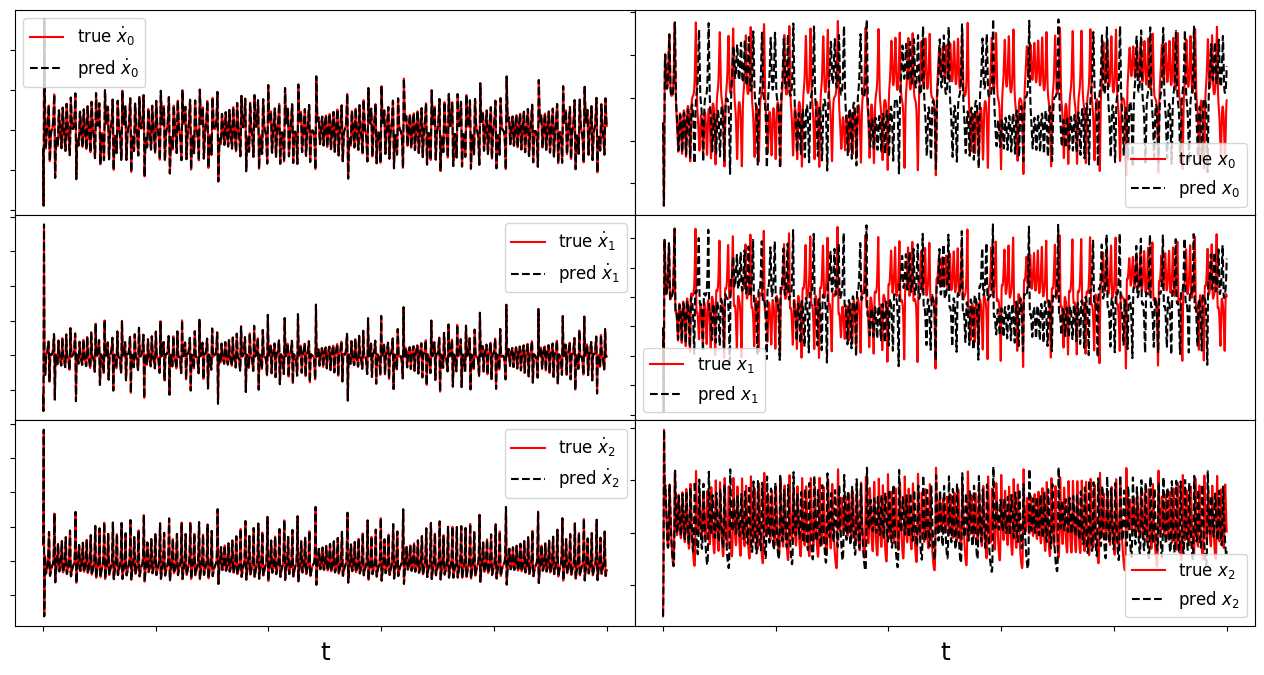

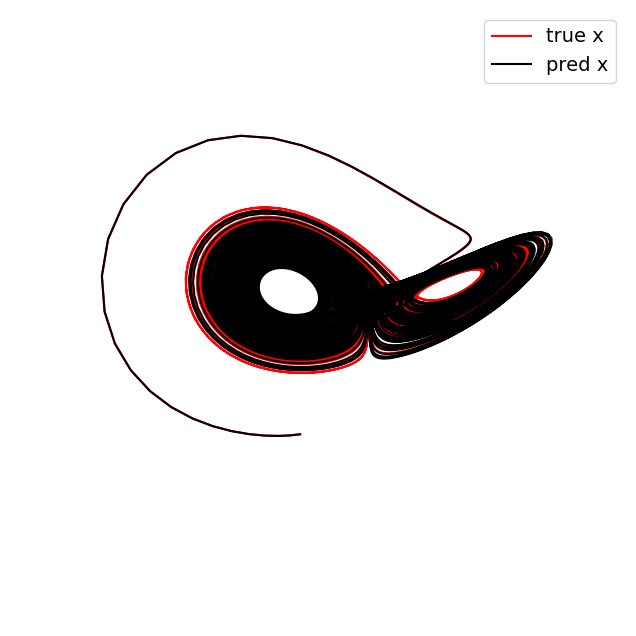

optimal m:  [-1.1598919  -0.12244458 36.74564581]
As eigvals:  [-10.0141668   -2.66230669  -0.93838016]
Estimate of trapping region size, Rm =  105.19082697129966
Normalized trapping region size, Reff =  4.4367936589400925
Frobenius error =  0.7269189253531968
Frobenius coefficient error =  1.4989984052599905
Time-averaged derivative error =  1.0832957179907218e-05


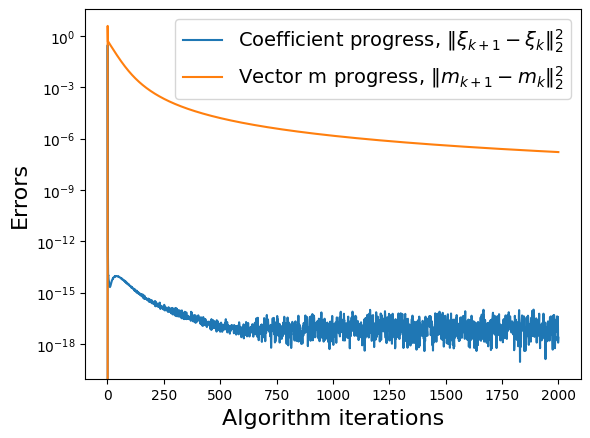

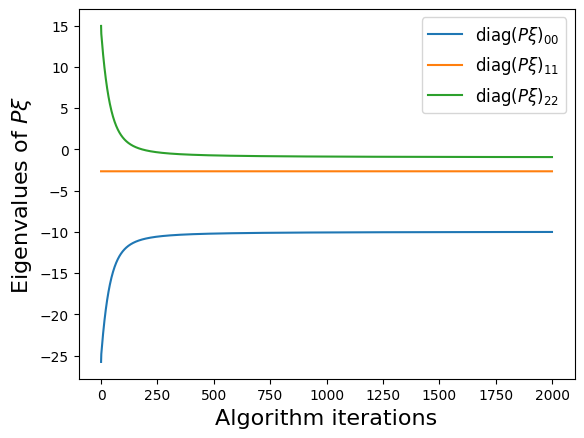

In [37]:
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')
make_3d_plots(x_test, x_test_pred, 'lorenz')
make_progress_plots(r, sindy_opt)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)

# compute relative Frobenius error in the model coefficients
sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1
coef_pred = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

In [6]:
# Import simulated annealing algorithm from scipy
from scipy.optimize import dual_annealing as anneal_algo

# define the objective function to be minimized by simulated annealing
def obj_function(m, L_obj, Q_obj, P_obj):
    mQ_full = np.tensordot(Q_obj, m, axes=([2], [0]))
    As = L_obj + P_obj @ mQ_full
    eigvals, eigvecs = np.linalg.eigh(As)
    return(eigvals[-1])

boundvals = np.zeros((r, 2))
boundmax = 1000
boundmin = -1000
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

PL_tensor_unsym = sindy_opt.PL_unsym_
PL_tensor = sindy_opt.PL_
PM_tensor = sindy_opt.PM_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PM_tensor, Xi, axes=([4, 3], [0, 1]))
# run simulated annealing 
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(L, Q, np.eye(r)), 
                       maxiter=500)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

Result:
Optimal m =  [1000.           -9.74685483   39.00724789]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -1.0647736012882472 



### Promoting locally stable models with estimates of the stability radius
So far, we have promoted globally stable models with trapping SINDy by enforcing the skew-symmetry structure in the nonlinearities as a hard constraint in the optimization problem:
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A)  \quad s.t. \quad Q_{ijk} + Q_{jik} + Q_{kji} = 0.$$
This problem is solved with a convex relaxation. Below, we relax the hard constraint slightly and instead solve 
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A)  \quad s.t. \quad -\epsilon_Q \leq Q_{ijk} + Q_{jik} + Q_{kji} \leq \epsilon_Q.$$ 
This allows us to build locally Lyapunov stable models, and adjust the size of the local stability radius by varying $\epsilon_Q$. A conservative estimate of the local stability is:
$$\rho_+ = \frac{3}{2r^{\frac{3}{2}}\epsilon_Q} \left( \sqrt{\lambda^2_{\text{max}}(\textbf{A}_S) - \frac{4r^{\frac{3}{2}}\epsilon_Q}{3}\|\mathbf{d}\|_2} - \lambda_{\text{max}}(\textbf{A}_S) \right).$$

In [31]:
max_iter = 400
eta = 1e2
threshold = 1.0
alpha_m = 5e-1 * eta
eps_Q = 1e-2
gamma = -0.1

# Setup the inequality constraints
constraint_zeros, constraint_matrix = make_constraints(r)
constraint_zeros_extended = np.ones(len(constraint_zeros) * 2) * eps_Q
constraint_zeros_extended[len(constraint_zeros):] = eps_Q
constraint_matrix_extended = np.zeros((len(constraint_zeros) * 2, constraint_matrix.shape[-1]))
constraint_matrix_extended[:len(constraint_zeros), :] = constraint_matrix
constraint_matrix_extended[len(constraint_zeros):, :] = -constraint_matrix

# run trapping SINDy
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m, gamma=gamma,
    max_iter=max_iter,
    constraint_lhs=constraint_matrix_extended,
    constraint_rhs=constraint_zeros_extended,
    constraint_order="feature",
    verbose=True,
    # verbose_cvxpy=True,
    inequality_constraints=True,
    eps_solver=1e-3
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 4.011e+02 ... 1.127e+00 ... 5.40e+01 ... 4.82e-21 ... 1.98e-23 ... 4.56e+02
   40 ... 4.012e+02 ... 2.048e-02 ... 5.40e+01 ... 4.82e-21 ... 1.98e-23 ... 4.55e+02
   80 ... 4.012e+02 ... 1.850e-03 ... 5.40e+01 ... 4.82e-21 ... 1.98e-23 ... 4.55e+02
  120 ... 4.013e+02 ... 3.075e-04 ... 5.40e+01 ... 4.82e-21 ... 1.98e-23 ... 4.55e+02
  160 ... 4.013e+02 ... 6.476e-05 ... 5.40e+01 ... 4.82e-21 ... 1.98e-23 ... 4.55e+02
  200 ... 4.013e+02 ... 1.513e-05 ... 5.40e+01 ... 4.82e-21 ... 1.98e-23 ... 4.55e+02
  240 ... 4.013e+02 ... 3.711e-06 ... 5.40e+01 ... 4.82e-21 ... 1.98e-23 ... 4.55e+02
  280 ... 4.013e+02 ... 9.323e-07 ... 5.40e+01 ... 4.82e-21 ... 1.98e-23 ... 4.55e+02
  320 ... 4.013e+02 ... 2.370e-07 ... 5.40e+01 ... 4.82e-21 ... 1.98e-23 ... 4.55e+02
  360 ... 4.013e+02 ... 6.062e-08 ... 5.40e+01 ... 4.82e-21 ... 1.98e-23 ... 4.55e+02
(x0)' = 0.011 1 + -10.081 x0 + 10.054 x1 + -0.002 x

F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:883: ConvergenceWarning: TrappingSR3._reduce did not converge after 400 iters.
  warnings.warn(


### Check inequality constraints are working!
Note that this may fail if the CVXPY solver error tolerance is too low. In that case, increase the value of eps_solver.

In [ ]:
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
print(np.max(Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))

### Plot how the local stability radius changes as the algorithm iterates
As the algorithm iterates, it is biasing the model to have a negative definite $\mathbf{A}^S$ matrix. Once this is true, we can estimate the local Lyapunov stability radius $\rho$, and see that as the algorithm promotes larger $-\lambda_1$ (the max eigenvalue of $\mathbf{A}^S$), the stability radius increases. 

In [ ]:
eigs = sindy_opt.PWeigs_history_
coef_history = sindy_opt.history_
rhos = []
for i in range(len(eigs)):
    if eigs[i][-1] < 0:
        # Q = np.tensordot(sindy_opt.PQ_, coef_history[i], axes=([4, 3], [1, 0]))
        # Q_sum = Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])
        rhos.append(-eigs[i][-1] / (2 * eps_Q))
        # rhos.append(-eigs[i][-1] / np.max(np.abs(Q_sum)))
plt.plot(rhos[1:])
plt.grid(True)
plt.ylabel('Stability radius')
plt.xlabel('Algorithm iteration')
plt.show()

### Check for unbounded trajectories
So we have used inequality constraints to promote locally Lyapunov stable models, and obtained an estimate of the stability radius. Let's verify that trajectories within this radius are bounded, but trajectories outside this radius can be unstable.

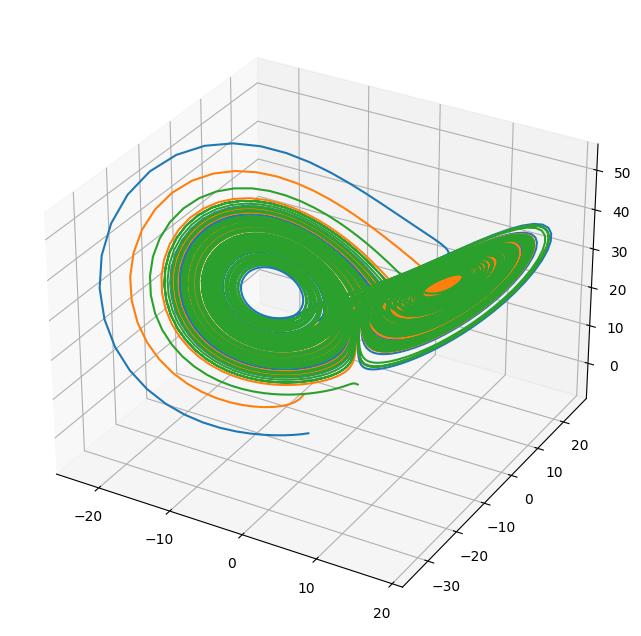

In [25]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
t_sim = t
for i in range(3):
    a0 = (np.random.rand(r) - 0.5) * 20  #* rhos[-1]
    x_traj = model.simulate(a0, t_sim)
    plt.plot(x_traj[:, 0], x_traj[:, 1], x_traj[:, -1])

We have relaxed the hard constraint slightly and solved the trapping SINDy objective function with inequality constraints dictating the amount of deviation allowed from perfect skew-symmetry in the quadratic coefficients:
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta^{-1} \lambda_1(\mathbf A)  \quad s.t. \quad -\epsilon_Q \leq Q_{ijk} + Q_{jik} + Q_{kji} \leq \epsilon_Q.$$ 
This allowed us to build locally Lyapunov stable models, and adjust the size of the local stability radius by varying $\epsilon_Q$. However, two other loss terms that can be used as alternatives to increase the size of the stability radius while avoiding extra constraints:
$$\alpha^{-1}\|Q_{ijk}\|$$
and
$$\beta^{-1}\|Q_{ijk} + Q_{jki} + Q_{kij}\|.$$
We can combine all of these options into the following unconstrained optimization problem:
$$argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta^{-1} \lambda_1(\mathbf A) + \alpha^{-1}\|Q_{ijk}\| + \beta^{-1}\|Q_{ijk} + Q_{jki} + Q_{kij}\|.$$
We now solve this problem for $\alpha \gg \beta$, $\alpha \ll \beta$, and $\alpha \sim \beta \sim 1.$

### First case: $\alpha \gg 1$, $\beta \ll 1$, for which the model should just zero out all the quadratic nonlinear terms

In [30]:
max_iter = 5000
eta = 1.0e2
alpha = 1e-20
beta = 1e20
threshold = 0
alpha_m = 1e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
print(np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))))

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 3.847e+07 ... 5.176e-01 ... 0.00e+00 ... 8.22e-05 ... 8.61e-45 ... 3.85e+07
(x0)' = 0.001 1 + -9.978 x0 + 9.978 x1
(x1)' = 1.899 1 + -12.735 x0 + 9.976 x1 + -0.006 x2
(x2)' = -0.495 1 + -0.235 x0 + 0.340 x1 + 0.014 x2
optimal m:  [-1.16595599 -0.55935101 -1.99977125]
As eigvals:  [-10.07350514   0.01163942  10.07426055]
Estimate of trapping region size, Rm =  -2.1853121455850135
Normalized trapping region size, Reff =  -0.08837504178857816
4.031794698631755e-13


### Second case: $\alpha \ll 1$, $\beta \gg 1$, which should reproduce the energy-preserving nonlinear constraint to high accuracy 

In [43]:
max_iter = 5000
eta = 1.0e5
alpha = 1e10
beta = 7e-8
threshold = 0
alpha_m = 1e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 5.827e+02 ... 1.270e-03 ... 0.00e+00 ... 4.93e-11 ... 2.02e+01 ... 6.03e+02
  500 ... 5.827e+02 ... 1.999e-06 ... 0.00e+00 ... 4.93e-11 ... 2.02e+01 ... 6.03e+02
 1000 ... 5.827e+02 ... 3.425e-07 ... 0.00e+00 ... 4.93e-11 ... 2.02e+01 ... 6.03e+02
 1500 ... 5.827e+02 ... 1.367e-07 ... 0.00e+00 ... 4.93e-11 ... 2.02e+01 ... 6.03e+02
 2000 ... 5.827e+02 ... 7.469e-08 ... 0.00e+00 ... 4.93e-11 ... 2.02e+01 ... 6.03e+02
 2500 ... 5.827e+02 ... 4.805e-08 ... 0.00e+00 ... 4.93e-11 ... 2.02e+01 ... 6.03e+02
 3000 ... 5.827e+02 ... 3.412e-08 ... 0.00e+00 ... 4.93e-11 ... 2.02e+01 ... 6.03e+02
 3500 ... 5.827e+02 ... 2.590e-08 ... 0.00e+00 ... 4.93e-11 ... 2.02e+01 ... 6.03e+02
 4000 ... 5.827e+02 ... 2.061e-08 ... 0.00e+00 ... 4.93e-11 ... 2.02e+01 ... 6.03e+02
 4500 ... 5.827e+02 ... 1.700e-08 ... 0.00e+00 ... 4.93e-11 ... 2.02e+01 ... 6.03e+02
(x0)' = -0.009 1 + -9.923 x0 + 9.961 x1 + -0.001 x0

F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:883: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  warnings.warn(


### Plot how the local stability radius changes as the algorithm iterates
As the algorithm iterates, it is biasing the model to have a negative definite $\mathbf{A}^S$ matrix. Once this is true, we can estimate the local Lyapunov stability radius $\rho$, and see that as the algorithm promotes larger $-\lambda_1$ (the max eigenvalue of $\mathbf{A}^S$), the stability radius increases. 

#### Note that with the soft constraint we can get the stability radius arbitrarily large here!

99.33252965395829


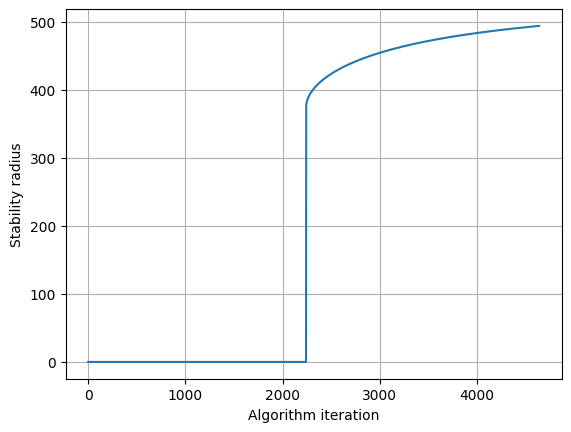

0.0012110215908396667


In [48]:
make_DA_progress_plots(r, np.eye(r), sindy_opt)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print(np.max(np.abs(Q_sum)))

### Check for unbounded trajectories
So we have used inequality constraints to promote locally Lyapunov stable models, and obtained an estimate of the stability radius. Let's verify that trajectories within this radius are bounded, but trajectories outside this radius can be unstable.

optimal m:  [-1.16101145 -0.11713498 36.98747376]
As eigvals:  [-10.00087921  -2.65035334  -0.94631716]
Estimate of trapping region size, Rm =  493.5919489798042
Normalized trapping region size, Reff =  20.81897911055485


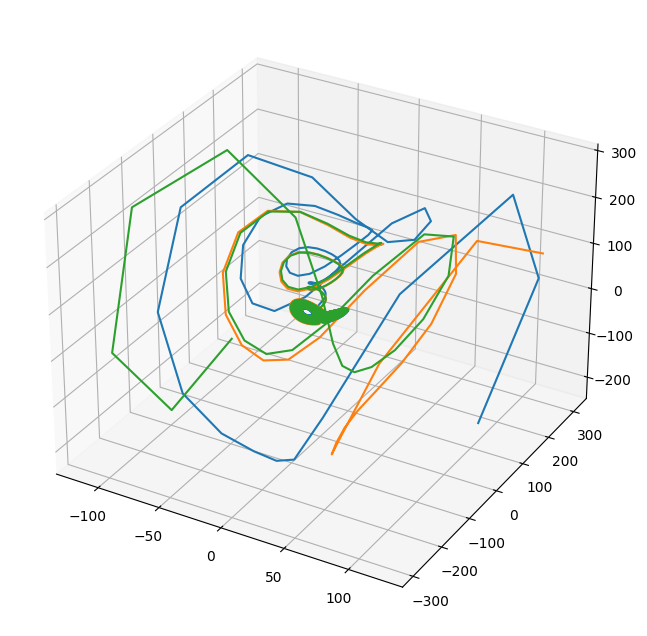

In [52]:
rho = check_stability_new(r, Xi, np.eye(r), sindy_opt, mean_val)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
t_sim = t
for i in range(3):
    a0 = (np.random.rand(r) - 0.5) * rho
    x_traj = model.simulate(a0, t_sim)
    plt.plot(x_traj[:, 0], x_traj[:, 1], x_traj[:, -1])

### Repeat $\alpha \gg 1$, $\beta \ll 1$ case with $\lambda > 0$
I find that solver will fail if eps_solver parameter is made too small (error tolerance of the CVXPY solver is very stringent)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 6.343e+02 ... 1.273e+00 ... 2.67e+02 ... 4.94e-21 ... 7.61e+06 ... 7.61e+06
   10 ... 6.344e+02 ... 1.425e-01 ... 2.67e+02 ... 4.94e-21 ... 3.63e+06 ... 3.63e+06
   20 ... 6.344e+02 ... 3.443e-02 ... 2.67e+02 ... 4.93e-21 ... 4.19e+06 ... 4.19e+06
   30 ... 6.344e+02 ... 1.223e-02 ... 2.67e+02 ... 4.93e-21 ... 4.11e+06 ... 4.11e+06
   40 ... 6.345e+02 ... 5.694e-03 ... 2.67e+02 ... 4.93e-21 ... 3.96e+06 ... 3.96e+06
   50 ... 6.345e+02 ... 3.160e-03 ... 2.67e+02 ... 4.93e-21 ... 3.79e+06 ... 3.80e+06
   60 ... 6.345e+02 ... 1.971e-03 ... 2.67e+02 ... 4.93e-21 ... 3.79e+06 ... 3.79e+06
   70 ... 6.345e+02 ... 1.334e-03 ... 2.67e+02 ... 4.93e-21 ... 3.64e+06 ... 3.64e+06
   80 ... 6.345e+02 ... 9.577e-04 ... 2.67e+02 ... 4.93e-21 ... 3.54e+06 ... 3.54e+06
   90 ... 6.345e+02 ... 7.189e-04 ... 2.67e+02 ... 4.93e-21 ... 3.47e+06 ... 3.47e+06


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:883: ConvergenceWarning: TrappingSR3._reduce did not converge after 100 iters.
  warnings.warn(


(x0)' = -0.036 1 + -9.879 x0 + 9.940 x1 + 0.003 x2 + -0.003 x0x2 + 0.001 x1x2
(x1)' = -0.023 1 + 27.784 x0 + -0.928 x1 + 0.004 x2 + -0.994 x0x2 + -0.001 x1x2
(x2)' = 0.084 1 + -0.004 x0 + -2.664 x2 + 0.993 x0x1 + 0.003 x0x0 + 0.001 x1x1
optimal m:  [-1.1621959  -0.12821075 34.55595812]
As eigvals:  [-10.27875201  -2.66314631  -0.66572102]
Estimate of trapping region size, Rm =  139.25494771769962
Normalized trapping region size, Reff =  5.6315349954381215
1.2102017207717836e-07


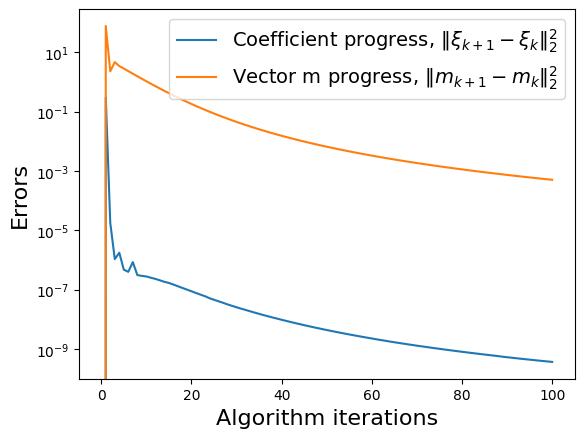

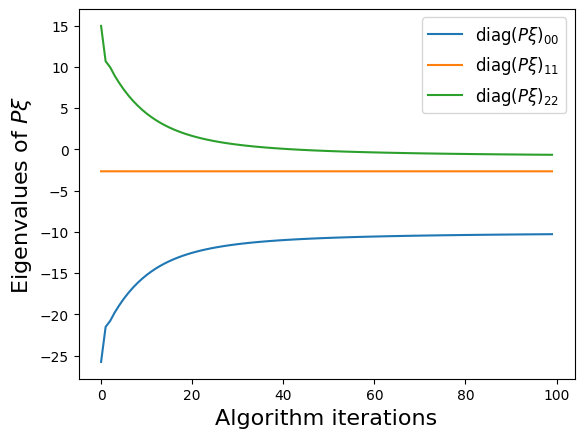

In [24]:
max_iter = 100
eta = 1.0e2
alpha = 1e20
beta = 1e-20
threshold = 5
alpha_m = 9e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    gamma=-1,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
    eps_solver=1e-3
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
print(np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))))
make_progress_plots(r, sindy_opt)

In [ ]:
eigs = sindy_opt.PWeigs_history_
coef_history = sindy_opt.history_
rhos = []
for i in range(len(eigs)):
    if eigs[i][-1] < 0:
        Q = np.tensordot(sindy_opt.PQ_, coef_history[i], axes=([4, 3], [1, 0]))
        Q_sum = Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])
        # rhos.append(-eigs[i][-1] / (2 * eps_Q))
        rhos.append(-eigs[i][-1] / np.max(np.abs(Q_sum)))
plt.plot(rhos[1:])
plt.grid(True)
plt.ylabel('Stability radius')
plt.xlabel('Algorithm iteration')
plt.show()
print(np.max(np.abs(Q_sum)))

### Dysts database contains a number of quadratically nonlinear chaotic systems with the special energy-preserving nonlinear symmetry.
You will need to install the dysts database with 'pip install dysts' or similar command (see https://github.com/williamgilpin/dysts)

In [ ]:
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
from dysts.analysis import sample_initial_conditions
from dysts.equation_utils import *

def load_data(
    systems_list,
    all_properties,
    n=200,      
    pts_per_period=20,
    random_bump=False,
    include_transients=False,
    n_trajectories=20,
):      
    all_sols_train = dict()
    all_sols_test = dict()
    all_t_train = dict()
    all_t_test = dict()

    for i, equation_name in enumerate(systems_list):
        eq = getattr(flows, equation_name)()
        all_sols_train[equation_name] = []
        all_sols_test[equation_name] = []
        all_t_train[equation_name] = []
        all_t_test[equation_name] = []
        print(i, eq)

        for j in range(n_trajectories):
            ic_train, ic_test = sample_initial_conditions(
                eq, 2, traj_length=1000, pts_per_period=30
            )

            # Kick it off the attractor by random bump with, at most, 1% of the norm of the IC
            if random_bump:
                ic_train += (np.random.rand(len(ic_train)) - 0.5) * abs(ic_train) / 50
                ic_test += (np.random.rand(len(ic_test)) - 0.5) * abs(ic_test) / 50

            # Sample at roughly the smallest time scale!!
            if include_transients:
                pts_per_period = int(1 / (all_properties[equation_name]["dt"] * 10))
                n = pts_per_period * 10  # sample 10 periods at the largest time scale

            eq.ic = ic_train
            t_sol, sol = eq.make_trajectory(
                n,
                pts_per_period=pts_per_period,
                resample=True,
                return_times=True,
                standardize=False,
            )
            all_sols_train[equation_name].append(sol)
            all_t_train[equation_name].append(t_sol)
            eq.ic = ic_test
            t_sol, sol = eq.make_trajectory(
                n,
                pts_per_period=pts_per_period,
                resample=True,
                return_times=True,
                standardize=False,
            )
            all_sols_test[equation_name].append(sol)
            all_t_test[equation_name].append(t_sol)
    return all_sols_train, all_t_train, all_sols_test, all_t_test


# Arneodo does not have the Lyapunov spectrum calculated so omit it.
# HindmarshRose and AtmosphericRegime seem to be poorly sampled
# by the dt and dominant time scales used in the database, so we omit them.
trapping_system_list = np.array([2, 3, 7, 10, 18, 24, 27, 29, 30, 34, 40, 46, 47, 66, 67])
systems_list = [
                "Aizawa", "Bouali2", 
                "GenesioTesi", "HyperBao", "HyperCai", "HyperJha", 
                "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka",
                "HenonHeiles", "GuckenheimerHolmes", "Halvorsen", "KawczynskiStrizhak",
                "VallisElNino", "RabinovichFabrikant", "NoseHoover", "Dadras", "RikitakeDynamo",
                "NuclearQuadrupole", "PehlivanWei", "SprottTorus", "SprottJerk", "SprottA", "SprottB",
                "SprottC", "SprottD", "SprottE", "SprottF", "SprottG", "SprottH", "SprottI", "SprottJ",
                "SprottK", "SprottL", "SprottM", "SprottN", "SprottO", "SprottP", "SprottQ", "SprottR",
                "SprottS", "Rucklidge", "Sakarya", "RayleighBenard", "Finance", "LuChenCheng",
                "LuChen", "QiChen", "ZhouChen", "BurkeShaw", "Chen", "ChenLee", "WangSun", "DequanLi",
                "NewtonLiepnik", "HyperRossler", "HyperQi", "Qi", "LorenzStenflo", "HyperYangChen", 
                "HyperYan", "HyperXu", "HyperWang", "Hadley",
               ]
alphabetical_sort = np.argsort(systems_list)
systems_list = (np.array(systems_list)[alphabetical_sort])[trapping_system_list]

# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "lyapunov_spectrum_estimated",
    "embedding_dimension",
    "parameters",
    "dt",
    "hamiltonian",
    "period",
    "unbounded_indices"
]

# Get attributes
all_properties = dict()
for i, equation_name in enumerate(systems_list):
    eq = getattr(flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    
# Get training and testing trajectories for all the experimental systems 
n = 1000  # Trajectories with 1000 points
pts_per_period = 100  # sample them with 100 points per period
n_trajectories = 1  # generate 5 trajectories starting from different initial conditions on the attractor
all_sols_train, all_t_train, all_sols_test, all_t_test = load_data(
    systems_list, all_properties, 
    n=n, pts_per_period=pts_per_period,
    random_bump=False,  # optionally start with initial conditions pushed slightly off the attractor
    include_transients=False,  # optionally do high-resolution sampling at rate proportional to the dt parameter 
    n_trajectories=n_trajectories
)

In [ ]:
num_attractors = len(systems_list)

# Calculate some dynamical properties
lyap_list = []
dimension_list = []
param_list = []

# Calculate various definitions of scale separation
scale_list_avg = []
scale_list = []
linear_scale_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    dimension_list.append(all_properties[system]['embedding_dimension'])
    param_list.append(all_properties[system]['parameters'])
    
    # Ratio of dominant (average) to smallest timescales
    scale_list_avg.append(all_properties[system]['period'] / all_properties[system]['dt'])


# Get the true coefficients for each system
true_coefficients = make_dysts_true_coefficients(systems_list, 
                                                 all_sols_train, 
                                                 dimension_list, 
                                                 param_list)

In [ ]:
for i in range(len(systems_list)):
# define parameters
    print(i, systems_list[i])
    r = dimension_list[i]
    N = int((r ** 2 + 3 * r) / 2.0)
    # make training and testing data
    t = all_t_train[systems_list[i]][0]
    x_train = all_sols_train[systems_list[i]][0]
    x_test = all_sols_test[systems_list[i]][0]

    # define hyperparameters
    threshold = 0
    max_iter = 2000
    eta = 1.0e3
    constraint_zeros, constraint_matrix = make_constraints(r)

    alpha_m = 4e-2 * eta  # default is 1e-2 * eta so this speeds up the code here
    accel = True  # use acceleration for the update of (m, A), sometimes is faster

    # run trapping SINDy
    sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                               accel=accel, max_iter=max_iter, gamma=-1,
                               constraint_lhs=constraint_matrix,
                               constraint_rhs=constraint_zeros,
                               constraint_order="feature",
                               verbose=True
                               )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t, quiet=True)
    model.print()

    Xi = model.coefficients().T
    Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
    print('nonlinearity preservation breaking = ', np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))))
    xdot_test = model.differentiate(x_test, t=t)
    xdot_test_pred = model.predict(x_test)
    x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)
    plt.figure(i + 1)
    plt.plot(x_train[:, 0], x_train[:, 1])
    plt.plot(x_train_pred[:, 0], x_train_pred[:, 1])
    check_stability(r, Xi, np.eye(r), sindy_opt, 1.0)
    
    Xi_true = true_coefficients[i][:, :N + 1].T
    boundvals = np.zeros((r, 2))
    boundmax = 1000
    boundmin = -1000
    boundvals[:, 0] = boundmin
    boundvals[:, 1] = boundmax

    PL_tensor = sindy_opt.PL_
    PM_tensor = sindy_opt.PM_
    L = np.tensordot(PL_tensor, Xi_true, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PM_tensor, Xi_true, axes=([4, 3], [0, 1]))
    
    # run simulated annealing on the true system to make sure the system is amenable to trapping theorem
    algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                           args=(L, Q, np.eye(r)), 
                           maxiter=500)
    opt_m = algo_sol.x
    opt_energy = algo_sol.fun
    print('Simulated annealing managed to reduce the largest eigenvalue of A^S to eig1 = ', 
          opt_energy, '\n')
    print('Optimal m = ', opt_m)
#     make_progress_plots(r, sindy_opt)
plt.show()